# Robust Principal Component Analysis (RPCA)

In [78]:
# import packages
import librosa
from librosa.display import specshow, waveplot
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
# set window size and hop size
len_window = 1024
len_hop = 256

In [60]:
## to get music from youtube:
    # convert youtube video to mp3: https://ytmp3.cc/
    # then convert mp3 to wav: https://convertio.co/kr/mp3-wav/


# load music
#sound, sample_rate = librosa.load('MIR-1K/Wavfile/abjones_1_01.wav', mono=False)
sound, sample_rate = librosa.load('MIR-1K/Wavfile/amy_1_02.wav', mono=False)

#sound, sample_rate = librosa.load('input/redvelvet-redflavor.wav', mono=False)
#sound, sample_rate = librosa.load('input/twice-tt.wav', mono=False)

# convert stereo music to monaural file
mono = librosa.to_mono(sound)
# stft conversion
spectrogram_mono = librosa.stft(mono, n_fft=len_window, hop_length=len_hop).astype(np.float32)

/Users/rachelmoon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [61]:
# https://github.com/dganguli/robust-pca/blob/master/r_pca.py
class R_pca:
    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * self.norm_p(self.D, 2))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def norm_p(M, p):
        return np.sum(np.power(M, p))

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.norm_p(np.abs(self.D), 2)

        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)
            Yk = Yk + self.mu * (self.D - Lk - Sk)
            err = self.norm_p(np.abs(self.D - Lk - Sk), 2)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

In [62]:
RPCA = R_pca(spectrogram_mono)
L, S = RPCA.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 1853.381586963276
iteration: 100, error: 0.1519144459836804
iteration: 122, error: 0.0821289144053975


In [63]:
# binary time-frequency masking
# set gain = 1 as in the paper
M_b = 1 * (np.abs(S) > 2 * np.abs(L))

X_singing = np.multiply(M_b, spectrogram_mono)
X_music = np.multiply((1 - M_b), spectrogram_mono)

In [44]:
# plot too small so change this!

#RPCA.plot_fit()
#plt.show()

In [64]:
# L is the background music separated out from the original song
# S is the singing voice separated out from the original song
# If you don't use (binary) time frequency masking, then just use S
output = librosa.istft(S)

# output using binary time frequency masking
output_better = librosa.istft(X_singing)

In [65]:
librosa.output.write_wav(path = 'output/amy_1_02_voice.wav', y = output, sr = sample_rate, norm = False)

In [66]:
# with binary frequency mask
librosa.output.write_wav(path = 'output/amy_1_02_voice_mask.wav', y = output_better, sr = sample_rate, norm = False)

In [67]:
# output background music files

output_L=librosa.istft(L)
librosa.output.write_wav(path = 'output/amy_1_02_mr.wav', y = output_L, sr = sample_rate, norm = False)

output_L=librosa.istft(X_music)
librosa.output.write_wav(path = 'output/amy_1_02_mr_mask.wav', y = output_L, sr = sample_rate, norm = False)

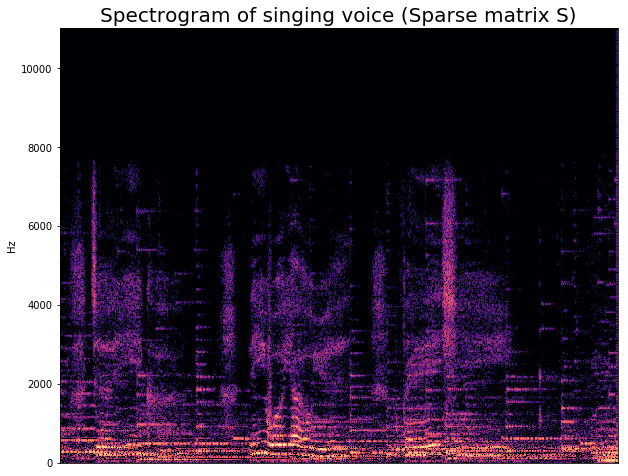

In [83]:
D = librosa.amplitude_to_db(np.abs(S), ref=np.max) # plot only S
plt.figure(figsize=(10,8))
librosa.display.specshow(D, y_axis='linear')
plt.title("Spectrogram of singing voice (Sparse matrix S)", fontsize=20)
plt.show()

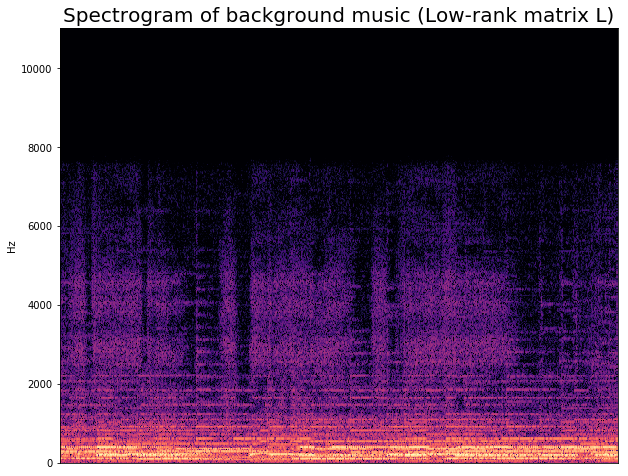

In [84]:
D = librosa.amplitude_to_db(np.abs(L), ref=np.max) # plot only L
plt.figure(figsize=(10,8))
librosa.display.specshow(D, y_axis='linear')
plt.title("Spectrogram of background music (Low-rank matrix L)", fontsize=20)
plt.show()

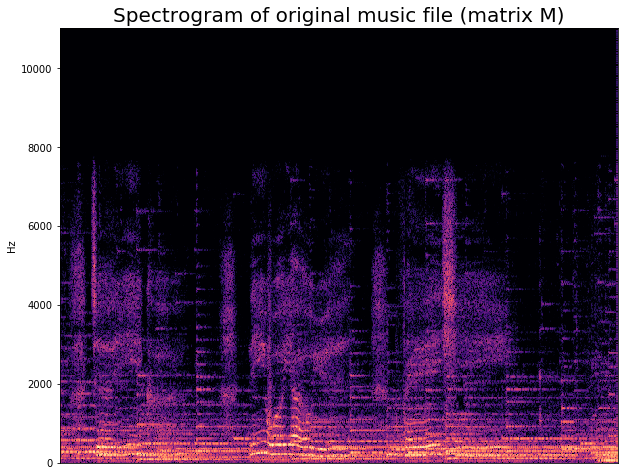

In [85]:
D = librosa.amplitude_to_db(np.abs(spectrogram_mono), ref=np.max) # plot the original spectrogram mono
plt.figure(figsize=(10,8))
librosa.display.specshow(D, y_axis='linear')
plt.title("Spectrogram of original music file (matrix M)", fontsize=20)
plt.show()

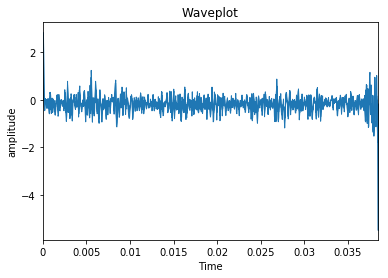

In [91]:
#https://librosa.github.io/librosa/generated/librosa.display.waveplot.html
plt.figure()
waveplot(L + S, sr=sample_rate)
plt.ylabel("amplitude")
plt.title("Waveplot")
plt.show()

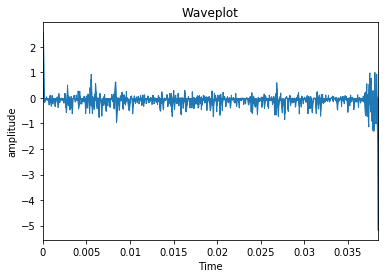

In [92]:
#https://librosa.github.io/librosa/generated/librosa.display.waveplot.html
plt.figure()
waveplot(S, sr=sample_rate)
plt.ylabel("amplitude")
plt.title("Waveplot")
plt.show()

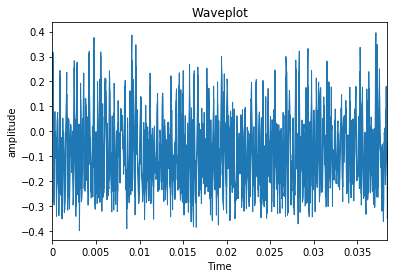

In [93]:
#https://librosa.github.io/librosa/generated/librosa.display.waveplot.html
plt.figure()
waveplot(L, sr=sample_rate)
plt.ylabel("amplitude")
plt.title("Waveplot")
plt.show()